In [1]:
""" Helper imports"""
import re
import joblib
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
import string
from datetime import date, timedelta
from collections import Counter
from operator import itemgetter

"""Modeling imports"""
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

""" Plotting imports"""
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# remove this later
pd.set_option('max_colwidth', 110)
import warnings
warnings.filterwarnings('ignore')

In [2]:
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from hdbscan import validity_index

In [3]:
data_path = '/home/jupyter/bi-topic-modeling/data/' 

STOP_WORDS = pd.read_pickle(data_path + 'forbes_stop_words.pkl')
"q1" in STOP_WORDS

True

### --- Input data ---

In [192]:
df = pd.read_csv(data_path + 'raw/articles.csv')

print("Shape:", df.shape)
print("Unique tiers:", len(df.tier1.unique()))

Shape: (992, 8)
Unique tiers: 29


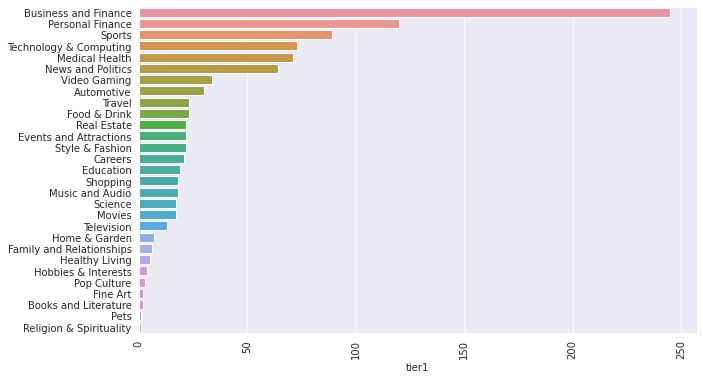

In [5]:
plt.figure(figsize=(10,6))
sns.barplot(x=df.tier1.value_counts(), y=df.tier1.value_counts().index)
plt.xticks(rotation=90)
plt.show()

In [193]:
df["article_length"] = df.clean_body.str.split().apply(len)
pd.DataFrame(df["article_length"].describe().astype(int))

,article_length
count,992
mean,872
std,497
min,5
25%,548
50%,773
75%,1031
max,4769


In [194]:
print(df[df["article_length"]==5].clean_body[275])
print()
df[df["article_length"]<100]

next 1000: small-scale super achievers.



,categoryName,tier1,tier2,content_natid,pub_date,title,body,clean_body,article_length
275,Startups,Business and Finance,Business,blogandpostid/blog/post/894-6024be3788d2130006b70fad,2021-02-16,Next 1000: Small-Scale Super Achievers,[id=34][id=36][id=40][id=41][id=45][id=46][id=50][id=53][id=55][id=58][id=60]<p><br></p>[id=64]<p> </p>[id...,next 1000: small-scale super achievers.,5
806,Medical Tests,Medical Health,Medical Tests,blogandpostid/blog/post/1509-60182e29ed8a540006e9a82a,2021-02-12,Event Test,"<h4 class=""subhead4-embed color-body bg-base font-accent font-size text-align""><br></h4><h2 class=""subhead...","event test. about fresh out of an unprecedented year, black and brown corporate professionals and entrepre...",53


* Per verdict from EDA, will be excluding articles less than 100 words

In [8]:
df = df[df["article_length"]>=100]
df = df.reset_index(drop=True)

In [9]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = nltk.word_tokenize(text)
    text = [x.lower() for x in text]
    text = [w for w in text if w not in STOP_WORDS]   
    text = [lemmatizer.lemmatize(x) for x in text]
    text = [w for w in text if w not in list(set(string.punctuation))]
    text = [re.sub('[^A-Za-z]+', '', x) for x in text] # remove numbers and special characters
    text = [x for x in text if len(x) > 1]
    
    return text

In [10]:
df['processed'] = df['clean_body'].apply(clean_text) 

In [11]:
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return all_nouns #' '.join(all_nouns)

df['processed_noun'] = df.clean_body.apply(nouns)

df['processed_noun_2'] = df.processed_noun.apply(lambda x: ' '.join([str(elem) for elem in list(set(x))]))

### --- Modeling ---

In [12]:
df.head(1)

,categoryName,tier1,tier2,content_natid,pub_date,title,body,clean_body,article_length,processed,processed_noun,processed_noun_2
0,Computer Software and Applications,Technology & Computing,Computing,blogandpostid/blog/post/6803-6023eb1ad61df20006dff468,2021-12-31,76% Of Smartphone Owners Use Mobile Apps To Manage Their Finances,"[id=23]<h2 class=""subhead-embed color-accent bg-base font-accent font-size text-align"">OBSERVATIONS FROM T...",76% of smartphone owners use mobile apps to manage their finances. observations from the fintech snark tan...,777,"[smartphone, owner, mobile, manage, finance, observation, fintech, snark, tank, new, study, cornerstone, a...","[%, smartphone, owners, apps, finances, observations, fintech, snark, study, cornerstone, advisors, %, sma...",robinhood scale usage run providers karma fintech google bnpl service evidence bank millennials copy holde...


In [13]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 2)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

* Why BERT model distilbert-base-nli-mean-tokens? https://www.sbert.net/docs/pretrained_models.html trained for semantic similarity
    * Other option: could change to Universal Sentence Encoder via Spacy - gives better performance on similarity tasks
* Why UMAP? Why 15, 5 parameters?
* Why HDBSCAN? Why cluster size 5?

In [14]:
# FUNCTION FORMAT

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

def algo(data):
    
    # get embeddings
    article_embeddings = []
    for article_body in data:

        embedding_sent = []
        art_sentences = sent_tokenize(article_body)
        for sent in art_sentences:
            embedding_sent.append(model.encode(sent))

        art_embed = np.mean(embedding_sent, axis=0)

        article_embeddings.append(art_embed) 
    print("article_embeddings len:", len(article_embeddings))
    
    # dimensionality reduction
    umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(article_embeddings) #min_dist=0.0,
    
    # cluster
    cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)
    
    # plot clusters and outliers
    # prepare data  - reduce to 2D for the purpose of plotting
    umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(article_embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD') #, s=20 lw=10
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r') # s=0.05, lw=10
    plt.colorbar()
    
    # put topics in dataframe
    docs_df = pd.DataFrame(data, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    
    # combine together all articles belonging to same cluster  
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
    
    # calculate countVector and tf-idf
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))
    
    # top n words, topic size
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
    topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)
    
    return docs_df, top_n_words, topic_sizes

992
article_embeddings len: 992


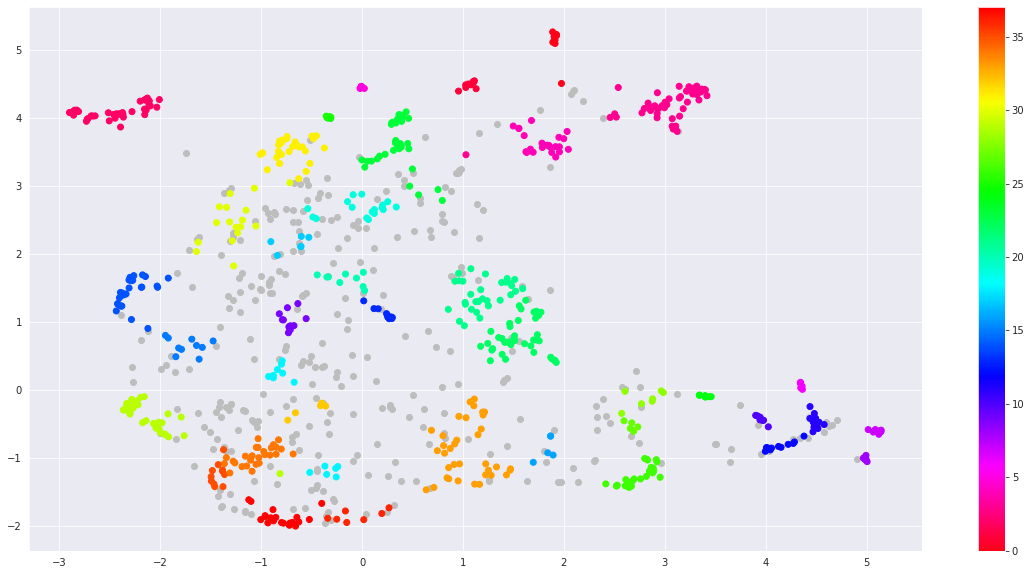

In [19]:
# SETTINGS - umap:n_neighbors=15, n_components=5, hdbscan min_cluster_size=5, input = full article

data = df.clean_body.tolist()
print(len(data))

docs_df, top_n_words, topic_sizes = algo(data) # 11.46

In [20]:
topic_sizes.sort_values('Topic')

,Topic,Size
0,-1,321
1,0,13
2,1,12
3,2,45
4,3,52
5,4,24
6,5,6
7,6,6
8,7,12
9,8,9


In [199]:
joined_df = docs_df.join(df[['tier1', 'title', 'content_natid', 'pub_date']])
# joined_df.to_csv("for_tomorrow.csv", index=False)
joined_df.head()

,Doc,Topic,Doc_ID,tier1,title,content_natid,pub_date
0,76% of smartphone owners use mobile apps to manage their finances. observations from the fintech snark tank a new study from cornerstone advisors found that 76% of all smartphone owners use mobile apps to manage their finances from fintech compan...,23,0,Technology & Computing,76% Of Smartphone Owners Use Mobile Apps To Manage Their Finances,blogandpostid/blog/post/6803-6023eb1ad61df20006dff468,2021-12-31
1,"buy churchill capital iv (cciv) on $12b lucid motors merge report. a former tesla tsla executive cofounded lucid motors in 2007. 14 years later reuters reported that lucid could go public via cciv, a special purpose acquisition company (spac), sp...",19,1,Automotive,Buy Churchill Capital IV (CCIV) On $12B Lucid Motors Merge Report,blogandpostid/blog/post/1468-602c35b19335830006abbd9c,2021-02-17
2,"iconic british audio brand unveils its first pair of active noise-canceling earphones. recently, kef, the iconic british speaker manufacturer, released its first-ever pair of anc (active noise-canceling) earphones. the new mu3 earphones were desi...",2,2,Technology & Computing,Iconic British Audio Brand Unveils Its First Pair Of Active Noise-Canceling Earphones,blogandpostid/blog/post/2978-602cdf4a937e4500069dc063,2021-02-17
3,"when hiring for your real estate business, focus on 'who' rather than 'what'. mike mcmullen is the ceo of prominence homes and the author of build. rent. sell. repeat! every business owner understands the misery of hiring the wrong person. i cert...",37,3,Real Estate,"When Hiring For Your Real Estate Business, Focus On 'Who' Rather Than 'What'",blogandpostid/blog/post/4972-602bd2797529240006822ee2,2021-02-17
4,"the good, the bad and the value of affiliate marketing. vp of marketing at clickbank , overseeing all marketing & education. in the world of digital advertising, there is not a more complex character than affiliate marketing. it has an interestin...",15,4,Business and Finance,"The Good, The Bad And The Value Of Affiliate Marketing",blogandpostid/blog/post/4254-602c1ff927035b000647a50b,2021-02-17


In [22]:
# modify top_n_words per topic dict into dataframe for presentation
topic_words_dict = {}  

for k, v in top_n_words.items():
    topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
topic_words_df = pd.DataFrame.from_dict(topic_words_dict, orient='index').reset_index().rename(columns={'index':'topic_num', 0:'top_20_words'}) 
topic_words_df

,topic_num,top_20_words
0,-1,"businesses, students, university, bitcoin, school, financial, energy, research, climate, startup, glenda, global, economic, technology, small, community, mascara, family, education, job"
1,0,"student loan, loan, student loans, loans, student, borrowers, forgiveness, loan forgiveness, cancellation, debt, loan cancellation, cancel, loan debt, 000 student, cancel student, biden, student debt, federal student, congress, repayment"
2,1,"texas, outages, storm, carbon monoxide, monoxide, weather, power, cold, monoxide poisoning, houston, power outages, poisoning, winter storm, blackouts, wind, temperatures, winter, ercot, tuesday, carbon"
3,2,"apple, batteries, s21, samsung, galaxy, battery, aa, inch, ultra, iphone, tv, laptop, android, s21 ultra, wireless, apples, rear, galaxy s21, features, aa batteries"
4,3,"trump, vote, sen, republicans, capitol, impeachment, gop, republican, senate, voted, convict, trial, donald, democrats, senators, trumps, romney, president, donald trump, saturday"
5,4,"vaccine, doses, novavax, pfizer, vaccines, cruise, moderna, astrazeneca, 19 vaccine, million doses, trials, shot, vaccination, coronavirus, vaccinated, cases, biontech, countries, dose, ambulance"
6,5,"detective chinatown, chinatown, detective, china, earned, cume, million domestic, domestic, weekend, opening weekend, avengers, endgame, avengers endgame, f9, box office, million china, imax, movie, debut, million day"
7,6,"wwe, nxt, wrestling, evans, elimination chamber, elimination, match, chamber, raw, wwes, def, smackdown, wwe raw, wwe nxt, miz, pro wrestling, million january, views, viewership, nia"
8,7,"arenado, cubs, yankees, pitchers, mets, home runs, darling, pitching, indians, bauer, runs, cutter, arrieta, spring training, contract, rockies, pitcher, league, ball, herrera"
9,8,"packers, quarterback, yards, giants, 49ers, vikings, green bay, cousins, nfl, bay, pass, defensive, offensive, san francisco, bears, francisco, san, quarterbacks, robinson, seasons"


**NMF on unassigned ones**

In [202]:
not_tagged = joined_df[joined_df.Topic==-1]
not_tagged.shape

(321, 7)

In [210]:
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return all_nouns #' '.join(all_nouns)

not_tagged['processed'] = not_tagged['Doc'].apply(clean_text) 
not_tagged['processed_noun'] = not_tagged.Doc.apply(nouns) 

In [211]:
not_tagged.head(1)

,Doc,Topic,Doc_ID,tier1,title,content_natid,pub_date,processed,processed_noun
5,"federal mask mandates: a step in the right direction. as part of the biden administration's plan to combat covid-19, an executive order was released on january 20th ""with the goal of maximizing public compliance with, and addressing any obstacles...",-1,5,News and Politics,Federal Mask Mandates: A Step In The Right Direction,blogandpostid/blog/post/5566-602d40ef7529240006416b74,2021-02-17,"[federal, mask, mandate, step, right, direction, biden, administration, plan, combat, covid, executive, order, released, th, goal, maximizing, public, compliance, addressing, obstacle, maskwearing, public, health, best, practice, identified, cdc,...","[mask, mandates, step, direction, part, administration, plan, covid-19, executive, order, goal, compliance, obstacles, health, practices, cdc, mask, mandate, step, direction, virus, lives, cdc, order, mask-wearing, conveyances, transportation, hu..."


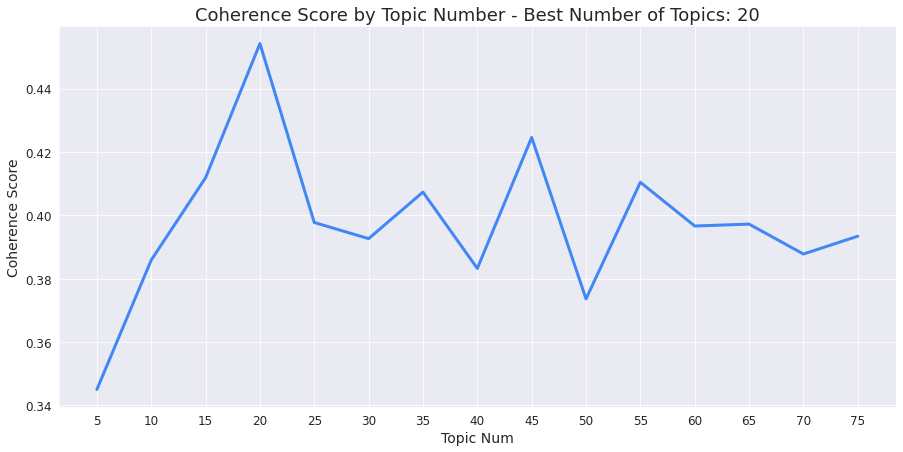

In [212]:
texts = not_tagged['processed_noun']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=3, no_above=0.85, keep_n=5000)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)
plt.show() # 7.11

In [ ]:
shortlisted = [i for i in scores if i[0]> len(not_tagged.tier1.unique())]
shortlisted

In [ ]:
best_num_topics = max(shortlisted,key=itemgetter(1))[0]
best_num_topics

In [ ]:
texts = not_tagged['processed']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.95,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(n_components=best_num_topics, init='nndsvd', max_iter=500, l1_ratio=0.0, solver='cd', alpha=0.0, tol=1e-4,
          random_state=1
).fit(tfidf) #1.50

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(7, 5, figsize=(40, 50), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
plot_top_words(nmf, tfidf_feature_names, 0,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

**LATEST LAST 2 DAYS**

In [169]:
#Query BQ into DF
client = bigquery.Client()

sql = """
    WITH content_iab AS (
        SELECT DISTINCT
        naturalId AS iab_natid,
        categoryName,
        tier1,
        tier2
      FROM
        `api-project-901373404215.Content.mnet_iab_categories`
      WHERE 
        tier1 IS NOT NULL
    ),
    
    content AS (
    SELECT distinct LOWER(naturalid) AS naturalid, SAFE.DATETIME(date, "America/New_York") AS publish_timestamp, title, body
        FROM (
            SELECT 
                naturalid, title, body, date, timestamp, RANK() OVER (PARTITION BY LOWER(naturalid) ORDER BY timestamp DESC) AS rank
            FROM `api-project-901373404215.Content.content`
            WHERE visible IS TRUE
                AND type in ('blog','blogslide','newsletter','magazine')
                AND date>=timestamp_sub(current_timestamp(), interval 7 day)
                AND timestamp>=timestamp_sub(current_timestamp(), interval 7 day)
                AND date<=current_timestamp()
        )
        WHERE
        rank=1
     )

    # Join the content iab table with the main content table to get the title with the iab category
      SELECT
        * 
        EXCEPT(iab_natid)
      FROM
        content
      LEFT JOIN
         content_iab
      ON
        LOWER(naturalid) = LOWER(iab_natid)
        ORDER BY publish_timestamp DESC
        """

# Send the query to the api and return a df
latest_df = client.query(sql).to_dataframe()
print("Shape: ", latest_df.shape)

Shape:  (2056, 7)


In [170]:
# Changing datatypes
latest_df['body']= latest_df['body'].astype(str)
latest_df['date'] = latest_df.publish_timestamp.dt.date
latest_df=latest_df.sort_values(by='date', ascending=False).reset_index(drop=True)

In [171]:
# lets just take 3rd Apr for now
latest_df.date.value_counts()

2021-03-31    496
2021-03-30    427
2021-04-01    393
2021-04-05    316
2021-04-02    237
2021-04-03     94
2021-04-04     81
2021-03-29     12
Name: date, dtype: int64

In [172]:
import datetime
latest_df = latest_df[latest_df.date == datetime.date(2021,4,3)]

In [173]:
# Combine title and body
latest_df['clean_body'] = latest_df['title'] + ". " + latest_df['body']

# Remove html, normalize unicode
latest_df['clean_body'] = latest_df['clean_body'].astype(str).str.lower()
latest_df['clean_body'] = latest_df['clean_body'].apply(remove_newline).astype(str)
latest_df['clean_body'] = latest_df['clean_body'].apply(expandContractions, c_re=c_re)
latest_df['clean_body'] = latest_df['clean_body'].apply(normalize_unicode)
latest_df['clean_body'] = latest_df['clean_body'].apply(remove_html).str.strip()
latest_df['clean_body'] = latest_df['clean_body'].apply(lambda x: re.sub(r"<[^>]*>", " ", x)) 
latest_df['clean_body'] = latest_df['clean_body'].replace('\s+', ' ', regex=True) # remove more than 1 space in between words

latest_df['processed'] = latest_df['clean_body'].apply(clean_text) 
latest_df.drop_duplicates("naturalid", inplace=True)
latest_df.reset_index(inplace=True)
latest_df.drop('index', axis=1, inplace=True)
latest_df.shape

(94, 10)

In [174]:
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return all_nouns #' '.join(all_nouns)

latest_df['processed_noun'] = latest_df.clean_body.apply(nouns) 

In [175]:
latest_df.tail(2)

,naturalid,publish_timestamp,title,body,categoryName,tier1,tier2,date,clean_body,processed,processed_noun
92,blogandpostid/blog/post/50769-606893c90bd89500060e6edc,2021-04-03 12:18:48,‘Not About Me’: Democratic Rep. Unimpressed After Amazon Apologizes For Lashing Out Over Workers Peeing In Bottles,"<h2 class=""topline-heading"">Topline</h2><p>After a spat between Amazon and Rep. Mark Pocan (D-Wisc.) over working conditions, the retail giant apologized to the member of Congress for denying its staff sometimes need to urinate in bottles—but Poc...",None,None,None,2021-04-03,"not about me: democratic rep. unimpressed after amazon apologizes for lashing out over workers peeing in bottles. topline after a spat between amazon and rep. mark pocan (d-wisc.) over working conditions, the retail giant apologized to the member...","[democratic, rep, unimpressed, amazon, apologizes, lashing, peeing, bottle, spat, amazon, rep, mark, pocan, dwisc, working, condition, retail, giant, apologized, member, congress, denying, staff, sometimes, need, urinate, bottlesbut, pocan, appea...","[rep., amazon, apologizes, workers, bottles, topline, spat, amazon, rep., mark, conditions, giant, member, congress, staff, apology, admission, facts, week, rebuffed, amazon, executive, clark, company, workplace, stories, staff, urinating, bottle..."
93,blogandpostid/blog/post/2279-6068b061581d4e0006ae57c2,2021-04-03 14:32:45,"Airline/Boeing Union Election Turns Ugly Amid Charges Of Theft, Coverup And Retaliation","[id=0]<p>At a time of increasing influence for the U.S. labor movement, the largest aviation and aerospace union is facing a divisive election for one of its top leadership posts.</p><p>In the election, Dora Cervantes, secretary treasurer of the...",Elections,News and Politics,Politics,2021-04-03,"airline/boeing union election turns ugly amid charges of theft, coverup and retaliation. at a time of increasing influence for the u.s. labor movement, the largest aviation and aerospace union is facing a divisive election for one of its top lead...","[airlineboeing, union, election, turn, ugly, amid, charge, theft, coverup, retaliation, increasing, influence, labor, movement, largest, aviation, aerospace, union, facing, divisive, election, top, leadership, election, dora, cervantes, secretary...","[union, election, charges, theft, coverup, retaliation, time, influence, labor, movement, aviation, aerospace, union, election, leadership, posts, election, dora, cervantes, secretary, treasurer, 600,000-member, association, machinists, post, sis..."


The Silhouette can be used to evaluate clustering results. It does so by comparing the average distance within a cluster with the average distance to the points in the nearest cluster.

94
article_embeddings len: 94


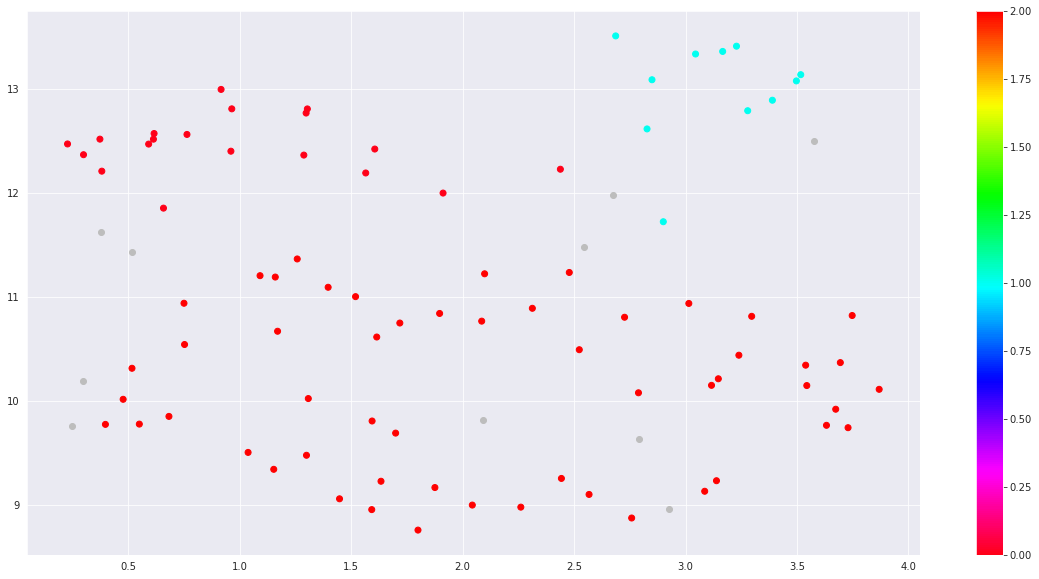

In [177]:
# SETTINGS - umap:n_neighbors=15, n_components=5, hdbscan min_cluster_size=5, input = full article

latest_data = latest_df.clean_body.tolist()
print(len(latest_data))

latest_docs_df, latest_top_n_words, latest_topic_sizes = algo(latest_data) # 4mins 

In [178]:
latest_topic_sizes.sort_values('Topic')

,Topic,Size
0,-1,10
1,0,19
2,1,11
3,2,54


In [179]:
latest_joined_df = latest_docs_df.join(latest_df[['tier1', 'title']])
latest_joined_df.head()

,Doc,Topic,Doc_ID,tier1,title
0,"as youtubes top music genre, hip-hop presents vast ad opportunity. following the launch of audio ads and music line-ups late last year, youtube recently announced that in q4 2020 hip-hop was the most viewed music genre on the platform. the video-...",-1,0,Music and Audio,"As YouTube’s Top Music Genre, Hip-Hop Presents Vast Ad Opportunity"
1,"the lesson from pioneers latest permian deal: bigger is better. when pioneer natural resources pxd hired former ceo scott sheffield to return to that role two years ago, rumors flew that his mission would be to high-grade and streamline the compa...",2,1,Business and Finance,The Lesson From Pioneer’s Latest Permian Deal: Bigger Is Better
2,"unexpected pandemic money lessons; bidens $2 trillion plan isnt enough. get forbes' top articles on pressing issues that matter to your financial well-beingpersonal finance, investing, taxes and retirement delivered to your inbox every week. the ...",2,2,None,Unexpected Pandemic Money Lessons; Biden’s $2 Trillion Plan Isn’t Enough
3,a small pennsylvania department store knows its customers and beats the odds. every town used to have a business like dunhams. these family-run department stores were a staple in downtown districts across the country. but as competition increased...,2,3,Events and Attractions,A Small Pennsylvania Department Store Knows Its Customers And Beats The Odds
4,"lsu wide receiver terrace marshall could shine with the green bay packers. note: the nfl draft begins april 29 and the green bay packers have the 29 th pick in the first round. between now and then, ill examine 29 players one per day the packers ...",0,4,Sports,LSU Wide Receiver Terrace Marshall Could Shine With The Green Bay Packers


In [180]:
latest_joined_df.to_csv("latest.csv")

In [181]:
# modify top_n_words dict into dataframe for presentation
latest_topic_words_dict = {}  

for k, v in latest_top_n_words.items():
    latest_topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
latest_topic_words_df = pd.DataFrame.from_dict(latest_topic_words_dict, orient='index').reset_index().rename(columns={'index':'topic_num', 0:'top_20_words'}) 
latest_topic_words_df

,topic_num,top_20_words
0,-1,"fees, totality, eclipse, hip hop, hop, hip, youn, affiliate, agents, game pass, patent, agents fees, affiliate marketing, device, pass, actress, marketing, 2024, path, transfer"
1,0,"garoppolo, gonzaga, kentucky derby, charts, baylor, ucla, marshall, stakes, movie, warriors, blue grass, kentucky, movies, races, quarterback, grass, santa, race, santa anita, trade"
2,1,"ds, ios, ev6, ios 14, laptop, starlink, battery, iphone, inch, range, kia, macbook, tesla, apple, x1, display, model, battery life, nano, design"
3,2,"capital, companies, driving cars, student loan, dividend, demolition, banks, sunscreen, ai, trump, human, lewis, management, election, jumio, dunhams, department, key, cancellation, retail"


**Compare NMF on 1 day**

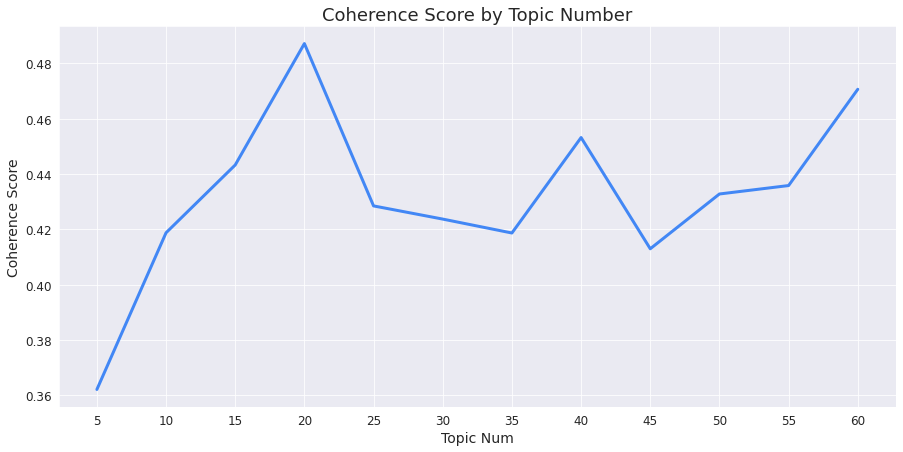

In [182]:
texts = latest_df['processed_noun']

dictionary = Dictionary(texts)
# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=3, no_above=0.85, keep_n=5000)
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers to try
topic_nums = list(np.arange(5, 60 + 1, 5))

coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot( topic_nums, coherence_scores, linewidth=3, color='#4287f5')

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
# plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.title('Coherence Score by Topic Number', fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)
plt.show() #3mins

In [183]:
texts = latest_df['processed_noun']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.95,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Run the nmf model with 10 topics
nmf = NMF(n_components=best_num_topics, init='nndsvd', max_iter=500, l1_ratio=0.0, solver='cd', alpha=0.0, tol=1e-4,
          random_state=1
).fit(tfidf) 

In [184]:
def topic_table(n_top_words, feature_names, model):
    topics = {}
    for i, topic_vec in enumerate(model.components_):
        topic_descr = ''
        for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
            topic_descr = topic_descr + feature_names[fid] + " "
        topics[i] = topic_descr
    return pd.DataFrame({'Top_Topic_Terms': topics})

docweights = nmf.transform(tfidf_vectorizer.transform(texts))
# using top 2 words to name the topic
n_top_words = 20

topic_df = topic_table(
    n_top_words, 
    tfidf_feature_names, nmf).T

topic_df = topic_df.T.reset_index()
topic_df

,index,Top_Topic_Terms
0,0,retirement tax bill plan house market markets year relief city money infrastructure dollars student package taxes president spending years loan
1,1,apple iphone apples watch leak release privacy mini feature capability move facebook phone app power step display year information sources
2,2,game playstation pass players xbox games level franchise outriders championship team houston show things design title end mlb stadium odds
3,3,film movie godzilla weekend trailer space theaters widow conversations james actress movies summer films bros flick king release kong likes
4,4,points charts rankings week movies place position netflix days georgia houston list programs odds show additions day march championship run
5,5,decision baseball braves game mlb atlanta media voting law league commissioner voter rob commissioner rob afternoon georgia voting law league baseball park fraud
6,6,car cars model battery range performance design miles power display drivers looks levels life bit models weight test minutes derby
7,7,capital round company companies market investment investors deal dividends firm business estate growth firms quarter income services law assets date
8,8,season pick show seasons draft scenes trailer quarterback league players something mvp trade bay summer stars team characters hes coach
9,9,derby stakes race races santa quality et horse cars run favorite reports bettors winner coverage saturday roses wagers spirit road


In [185]:
natid = latest_df['naturalid'].tolist()

df_temp = pd.DataFrame({ 'naturalid': natid, 'topic_num': docweights.argmax(axis=1)})

topic_df.rename(columns={"index":"topic_num"}, inplace=True)

merged_topic = df_temp.merge(topic_df, on='topic_num', how='left')
merged_topic
df_topics = pd.merge(latest_df, merged_topic, on='naturalid', how='left')
df_topics = df_topics.drop('processed',axis=1)

In [186]:
df_topics.topic_num.value_counts().sort_index()

0     5
1     5
2     6
3     6
4     2
5     4
6     5
7     7
8     7
9     2
10    4
11    5
12    3
13    6
14    3
15    6
16    3
17    6
18    3
19    6
Name: topic_num, dtype: int64

In [187]:
df_topics.to_csv("nmf_latest.csv", index=False)

In [89]:
# get embeddings
article_embeddings = []
for article_body in latest_df.clean_body.tolist():

    embedding_sent = []
    art_sentences = sent_tokenize(article_body)
    for sent in art_sentences:
        embedding_sent.append(model.encode(sent))

    art_embed = np.mean(embedding_sent, axis=0)

    article_embeddings.append(art_embed) 
print("article_embeddings len:", len(article_embeddings))

# article_embeddings = model.encode(latest_df.clean_body.tolist())

# dimensionality reduction
umap_embeddings = umap.UMAP(n_neighbors=15, 
                        n_components=5, 
                        metric='cosine').fit_transform(article_embeddings) #min_dist=0.0,

# cluster
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                      metric='euclidean',                      
                      cluster_selection_method='eom').fit(umap_embeddings) #8.59

from sklearn.metrics import davies_bouldin_score
print(round(metrics.calinski_harabasz_score(umap_embeddings, cluster.labels_)))
print(round(metrics.silhouette_score(umap_embeddings, cluster.labels_, metric='euclidean'), 2))
print(round(davies_bouldin_score(X, labels), 2))

0.5528190123564091

**HDBSCAN on one IAB category**

In [22]:
business_finance = df[df.tier1 == "Business and Finance"]
business_finance.head(2)

,categoryName,tier1,tier2,content_natid,pub_date,title,body,clean_body,article_length,processed,processed_noun,processed_noun_2
4,Marketing and Advertising,Business and Finance,Business,blogandpostid/blog/post/4254-602c1ff927035b000647a50b,2021-02-17,"The Good, The Bad And The Value Of Affiliate Marketing","<p><em>VP of Marketing at&nbsp;</em><a href=""http://www.clickbank.com/"" target=""_blank"" class=""color-link""...","the good, the bad and the value of affiliate marketing. vp of marketing at clickbank , overseeing all mark...",987,"[good, bad, value, affiliate, marketing, vp, marketing, clickbank, overseeing, marketing, education, world...","[value, affiliate, marketing, vp, marketing, clickbank, marketing, education, world, advertising, characte...",world character marketplace offerings spend grace fall individuals shapes work platform tools trial consum...
14,Human Resources,Business and Finance,Business,blogandpostid/blog/post/4254-60251edccdea920006b4b819,2021-02-17,11 Types Of Business Communication Best Handled By Phone,"<p>Digital communications dominate these days, both personally and professionally. As professional communi...","11 types of business communication best handled by phone. digital communications dominate these days, both...",886,"[type, business, communication, best, handled, phone, digital, communication, dominate, personally, profes...","[types, business, communication, phone, communications, days, communication, discussion, year, ubiquity, c...",world anything lidar motivations pitch collaboration work response support business computer scenarios sto...


245
article_embeddings len: 245


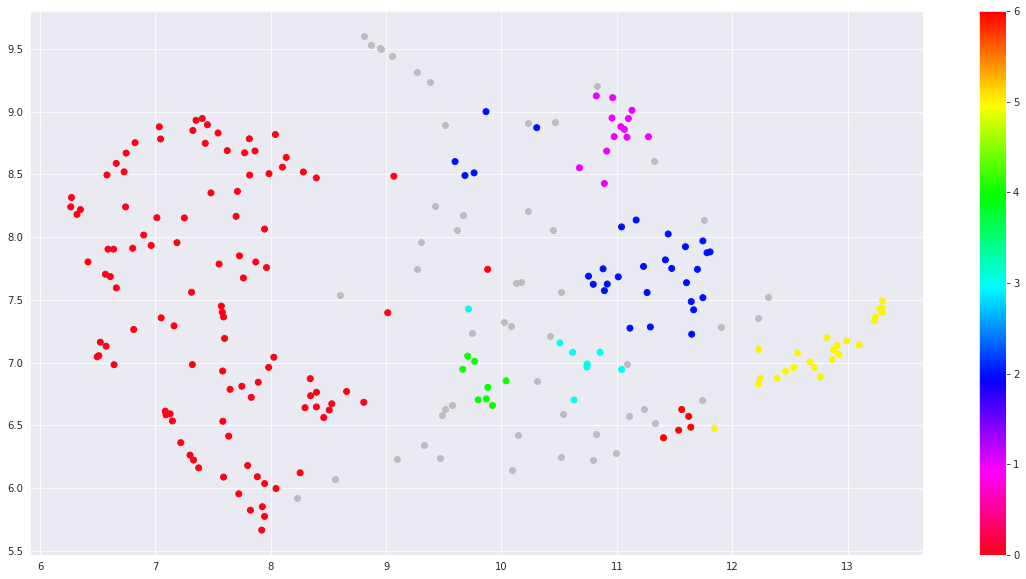

In [23]:
# SETTINGS - umap:n_neighbors=15, n_components=5, hdbscan min_cluster_size=5, input = full article

data = business_finance.clean_body.tolist()
print(len(data))

docs_df, top_n_words, topic_sizes = algo(data) # 5.36

In [24]:
joined_df = docs_df.join(df[['tier1', 'title', 'content_natid', 'pub_date']])
# modify top_n_words dict into dataframe for presentation
topic_words_dict = {}  

for k, v in top_n_words.items():
    topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
topic_words_df = pd.DataFrame.from_dict(topic_words_dict, orient='index').reset_index().rename(columns={'index':'topic_num', 0:'top_20_words'}) 
topic_words_df

,topic_num,top_20_words
0,-1,"pricing, flynt, ego, students, mais, trump, tax, reuben, isas, erp, vote, airlines, trial, event, visibility, property, impeachment, changes, rate, talent"
1,0,"hydrogen, 600, china, gas, erc, oil, electric, spouses, 50, production, worth billion, cryptocurrency, texas, biden, spouses net, wife, blockchain, 500, green, private"
2,1,"clubhouse, content, intent data, intent, personalized, marketers, phone, case studies, keywords, rooms, app, chat, google ads, customer support, chat rooms, ai, case study, law firms, senior care, berkowitz"
3,2,"workplace, remote, remote work, cisco, leadership, office, personal, hybrid, employers, learning, workers, burnout, lives, communication, purpose, performance management, homes, wethechange, hr, leaders"
4,3,"lean, cmos, agility, lean startup, agile, startup, stage, growth stage, idc, roughan, oman, product development, early stage, local content, development, stage companies, methodology, plexal, stage startup, cmo"
5,4,"fashion, affiliate, affiliate marketing, huang, digital fashion, bnpl, tickr, clothes, says huang, buying, digital ads, ad, affiliates, payment, clothing, kpis, buyers, dressx, mcgillycuddy, ads"
6,5,"keller, music, seymour, deon, special, blue horizon, tran, culture, brad, horizon, seo, blues, didnt, baltin, got, pitt, cola, zorc, elite, blue"
7,6,"influencer, translation, influencer marketing, outsourcing, localization, house influencer, translators, influencer agencies, agencies, business plan, judges, management team, influencers, beauty, smes, plan competitions, competitions, house, pag..."


In [26]:
joined_df.to_csv("busi_finance_tier.csv", index=False)